In [1]:
from sklearn.model_selection import train_test_split, cross_validate, KFold , cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import mlflow
import joblib

In [2]:
data = pd.read_csv('../data/ProcessedData.csv')
data.head()

,Area,PrivateGarden,price,total_rooms,Payment_Cash or Installment,Payment_Installment,Ownership_Primary,Status_Off-plan
0,150.0,1,7000000.0,6.0,False,False,True,False
1,235.0,0,7000000.0,6.0,False,False,False,False
2,170.0,1,7732255.0,6.0,False,True,True,True
3,135.0,0,5100000.0,4.0,False,True,False,False
4,165.0,0,6850000.0,6.0,False,False,False,False


In [3]:
X = data.drop('price',axis=1)
X.head()

,Area,PrivateGarden,total_rooms,Payment_Cash or Installment,Payment_Installment,Ownership_Primary,Status_Off-plan
0,150.0,1,6.0,False,False,True,False
1,235.0,0,6.0,False,False,False,False
2,170.0,1,6.0,False,True,True,True
3,135.0,0,4.0,False,True,False,False
4,165.0,0,6.0,False,False,False,False


In [4]:
y = data['price']
y.head()

0    7000000.0
1    7000000.0
2    7732255.0
3    5100000.0
4    6850000.0
Name: price, dtype: float64

### Linear Regression model

### Complexity curves

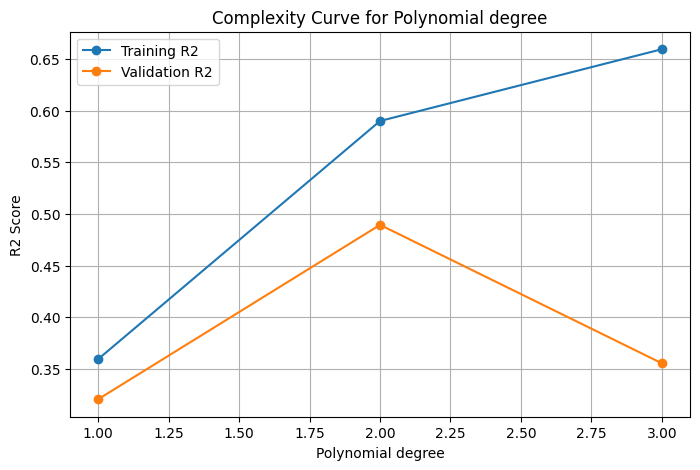

In [5]:
train_scores = []
val_scores = []

polynomial_degree = [1,2,3]
for x in polynomial_degree:
    model = Pipeline([
    ('poly', PolynomialFeatures(degree=x)),
    ("lr", LinearRegression())
    ])

    scores = cross_validate(
        model,
        X,
        y,
        cv=3,
        scoring="r2",
        return_train_score=True,
    )

    train_scores.append(scores['train_score'].mean())
    val_scores.append(scores['test_score'].mean())

plt.figure(figsize=(8, 5))

plt.plot(polynomial_degree, train_scores, label="Training R2", marker="o")
plt.plot(polynomial_degree, val_scores, label="Validation R2", marker="o")

plt.xlabel("Polynomial degree")
plt.ylabel("R2 Score")
plt.title("Complexity Curve for Polynomial degree")
plt.legend()
plt.grid(True)

plt.show()

The best model is at polynomial degree = 2

### Learning Curves

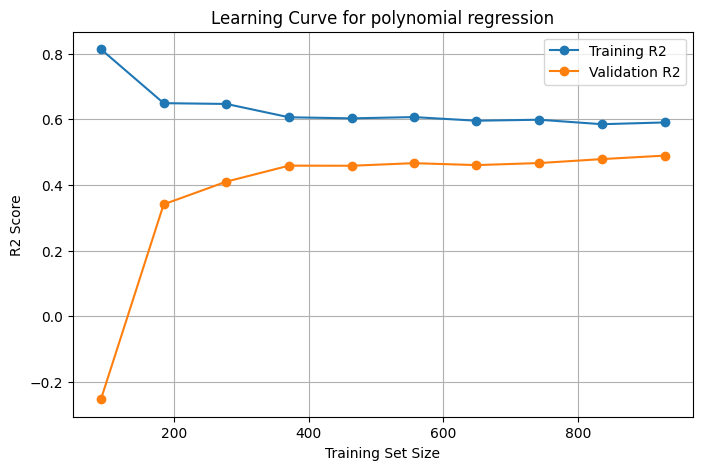

In [6]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("lr", LinearRegression())
    ])
train_sizes, train_scores, val_scores = learning_curve(
    estimator= model,
    X= X,
    y=y,
    train_sizes= np.linspace(.1,1,10),
    cv = 3,
    scoring = 'r2',
    shuffle = True
)

train_r2 = train_scores.mean(axis=1)
val_r2 = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))

plt.plot(train_sizes, train_r2, label="Training R2", marker="o")
plt.plot(train_sizes, val_r2, label="Validation R2", marker="o")

plt.xlabel("Training Set Size")
plt.ylabel("R2 Score")
plt.title("Learning Curve for polynomial regression")
plt.legend()
plt.grid(True)

plt.show()

### MLFlow

In [7]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Real Estate Price Prediction")
splits = 3
kf = KFold(shuffle=True, random_state=42, n_splits=splits)

with mlflow.start_run(run_name='Polynomial Regression'):
    model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("lr", LinearRegression())
    ])
    
    y_pred = cross_val_predict(model,X,y, cv=kf)
    score = r2_score(y,y_pred)
    model.fit(X,y)
    mlflow.log_param("Cross_validation_splits", splits)
    mlflow.log_param("polynomial_degree", 2)
    mlflow.log_metric('r2_score', score)
    mlflow.sklearn.log_model(sk_model=model, name="Polynomial_regression_model")    

🏃 View run Polynomial Regression at: http://localhost:5000/#/experiments/1/runs/11be97674ded46d991e821ba5f79c0ea
🧪 View experiment at: http://localhost:5000/#/experiments/1


### XGBoost Regressor

### Complexity curves

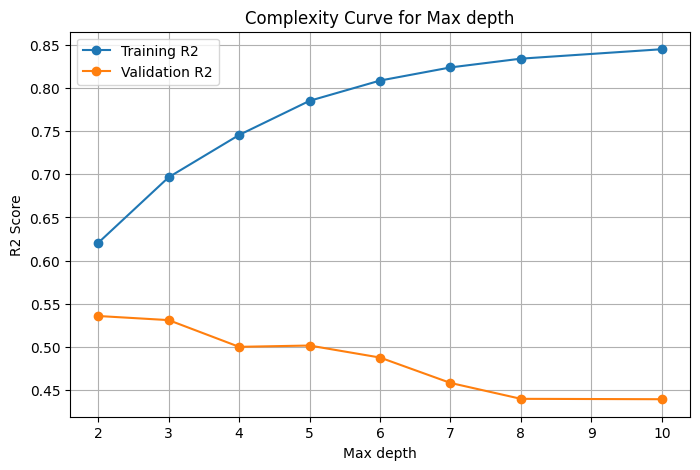

In [8]:
train_scores = []
val_scores = []

# max_depth

max_depth = [2, 3, 4, 5, 6, 7, 8, 10]
for x in max_depth:
    model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("xgb", XGBRegressor(
        n_estimators=45,
        learning_rate=0.1,
        max_depth=x,
        objective="reg:squarederror",
        random_state=42
    ))
    ])

    scores = cross_validate(
        model,
        X,
        y,
        cv=3,
        scoring="r2",
        return_train_score=True,
    )

    train_scores.append(scores['train_score'].mean())
    val_scores.append(scores['test_score'].mean())

plt.figure(figsize=(8, 5))

plt.plot(max_depth, train_scores, label="Training R2", marker="o")
plt.plot(max_depth, val_scores, label="Validation R2", marker="o")

plt.xlabel("Max depth")
plt.ylabel("R2 Score")
plt.title("Complexity Curve for Max depth")
plt.legend()
plt.grid(True)

plt.show()

The best point is at max_depth = 4

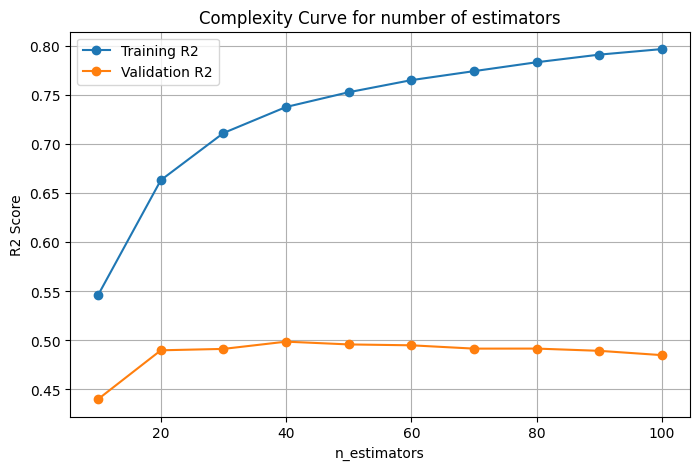

In [9]:
train_scores = []
val_scores = []

# n_estimators complexity curve

estimators = [10, 20, 30, 40, 50, 60, 70, 80,90,100]
for x in estimators:
    model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("xgb", XGBRegressor(
        n_estimators=x,
        learning_rate=0.1,
        max_depth=4,
        objective="reg:squarederror",
        random_state=42
    ))
    ])

    scores = cross_validate(
        model,
        X,
        y,
        cv=3,
        scoring="r2",
        return_train_score=True,
    )

    train_scores.append(scores['train_score'].mean())
    val_scores.append(scores['test_score'].mean())

    
plt.figure(figsize=(8, 5))

plt.plot(estimators, train_scores, label="Training R2", marker="o")
plt.plot(estimators, val_scores, label="Validation R2", marker="o")

plt.xlabel("n_estimators")
plt.ylabel("R2 Score")
plt.title("Complexity Curve for number of estimators")
plt.legend()
plt.grid(True)

plt.show()

We see that with number of estimators larger than 40, the validation score didn't increase and the model didn't learn additional information

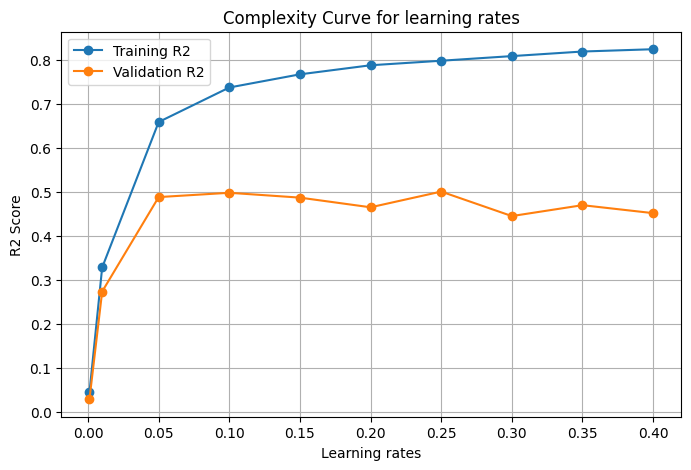

In [10]:
train_scores = []
val_scores = []

# learning_rate complexity curve

rates = [.001, .01, .05, .1, .15, .2, .25, .3,.35,.4]
for x in rates:
    model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("xgb", XGBRegressor(
        n_estimators=40,
        learning_rate=x,
        max_depth=4,
        objective="reg:squarederror",
        random_state=42
    ))
    ])

    scores = cross_validate(
        model,
        X,
        y,
        cv=3,
        scoring="r2",
        return_train_score=True,
    )

    train_scores.append(scores['train_score'].mean())
    val_scores.append(scores['test_score'].mean())

    
plt.figure(figsize=(8, 5))

plt.plot(rates, train_scores, label="Training R2", marker="o")
plt.plot(rates, val_scores, label="Validation R2", marker="o")

plt.xlabel("Learning rates")
plt.ylabel("R2 Score")
plt.title("Complexity Curve for learning rates")
plt.legend()
plt.grid(True)

plt.show()

The best learning rate is at learning_rate = .1

### Learning curves

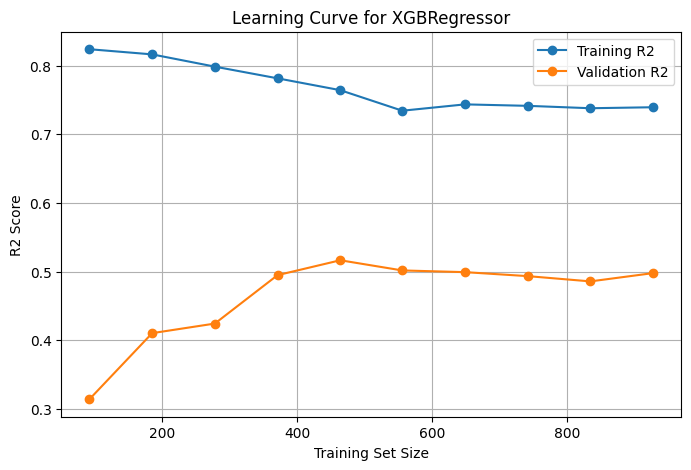

In [11]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("xgb", XGBRegressor(
        n_estimators=40,
        learning_rate=0.1,
        max_depth=4,
        objective="reg:squarederror",
        random_state=42
    ))
    ])
train_sizes, train_scores, val_scores = learning_curve(
    estimator= model,
    X= X,
    y=y,
    train_sizes= np.linspace(.1,1,10),
    cv = 3,
    scoring = 'r2',
    shuffle = True
)

train_r2 = train_scores.mean(axis=1)
val_r2 = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))

plt.plot(train_sizes, train_r2, label="Training R2", marker="o")
plt.plot(train_sizes, val_r2, label="Validation R2", marker="o")

plt.xlabel("Training Set Size")
plt.ylabel("R2 Score")
plt.title("Learning Curve for XGBRegressor")
plt.legend()
plt.grid(True)

plt.show()

In [12]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Real Estate Price Prediction")
splits = 3
kf = KFold(shuffle=True, random_state=42, n_splits=splits)
with mlflow.start_run(run_name='XGBoost Regression'):
    model = Pipeline([
    ("xgb", XGBRegressor(
        n_estimators=40,
        learning_rate=0.1,
        max_depth=4,
        objective="reg:squarederror",
        random_state=42
    ))
    ])
    
    y_pred = cross_val_predict(model,X,y, cv=kf)
    score = r2_score(y,y_pred)
    model.fit(X,y)
    mlflow.log_param("Cross_validation_splits", splits)
    mlflow.log_param("max_depth", 4)
    mlflow.log_param("n_estimators", 40)
    
    mlflow.log_metric('r2_score', score)
    mlflow.sklearn.log_model(sk_model=model, name="XGBoost_regression_model")

🏃 View run XGBoost Regression at: http://localhost:5000/#/experiments/1/runs/5f1c572e5a8e4e638e5d6797793e7a89
🧪 View experiment at: http://localhost:5000/#/experiments/1


It's Obvious that the XGBRegressor model is better than the Polynomial regression model

In [14]:
model = Pipeline([
    ("xgb", XGBRegressor(
        n_estimators=40,
        learning_rate=0.1,
        max_depth=4,
        objective="reg:squarederror",
        random_state=42
    ))
    ])
model.fit(X,y)
joblib.dump(model, '../models/model.pkl')

['../models/model.pkl']